In [354]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import functools

In [355]:
class BSDSDataset(Dataset):
    
    def __init__(self, root_dir, split='train', transform_img=None, transform_mask=None, fill_mask=False):
        self.root_dir = root_dir
        self.split = split
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        self.fill_mask = fill_mask
        self.image_dir = os.path.join(root_dir, 'BSDS500', 'data', 'images', split)
        self.gt_dir = os.path.join(root_dir, 'BSDS500', 'data', 'groundTruth', split)
        self.image_files = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.jpg')])
       
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load grayscale image
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Ensure gray is 2D
        if gray.ndim > 2:
            gray = gray[..., 0]
        # Convert gray to RGB
        image = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        # Construct corresponding ground truth .mat file
        gt_filename = os.path.splitext(self.image_files[idx])[0] + '.mat'
        gt_path = os.path.join(self.gt_dir, gt_filename)
        # Load ground truth from .mat file
        mat_data = sio.loadmat(gt_path)
        # Get first annotation of 1D array groundTruth
        gt_structs = mat_data['groundTruth'][0]
        # Create empty edge map (boolean) with same shape as image
        gt_edge = np.zeros((gray.shape[0], gray.shape[1]), dtype=bool)
        # Combine all annotations with logical OR
        for gt_item in gt_structs:
            # Index gt_item with [0] because its wrapped in extra layer
            annotation = np.array(gt_item[0]['Boundaries'][0])
            gt_edge = np.logical_or(gt_edge, annotation)
        # If result has extra channel, force it to 2D
        if gt_edge.ndim == 3:
            gt_edge = gt_edge[..., 0]
        # Convert Boolean edge map to uint8 (0 or 255)
        gt_edge = gt_edge.astype(np.uint8) * 255
        # Fill edge map into binary segmentation mask
        if self.fill_mask:
            # Find contours in edge map
            contours, _ = cv2.findContours(gt_edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            filled_mask = np.zeros_like(gt_edge)
            # Fill contours
            cv2.drawContours(filled_mask, contours, -1, color=255, thickness=cv2.FILLED)
            target_mask = filled_mask
        else:
            target_mask = gt_edge
        # Apply conversion to tensor
        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            gt_edge = self.transform_mask(gt_edge)
        return image, gt_edge

# Define transforms
# Transform image and mask to fixed size
transform_img = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
transform_mask = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

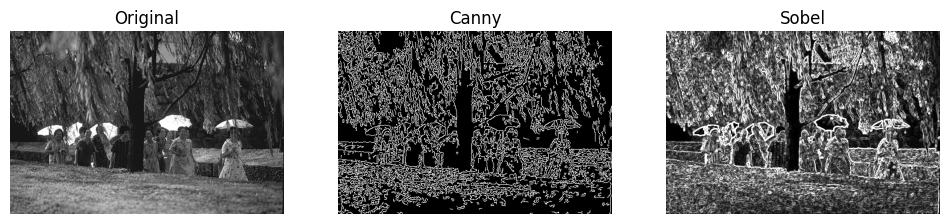

In [465]:
'''
Apply Canny edge detector.
'''
def apply_canny(image, low_threshold=100, high_threshold=200):
    # If image is 3-channel, convert to grayscale; else use it
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    edges = cv2.Canny(gray, low_threshold, high_threshold)
    return edges

'''
Apply Sobel filter in x and y directions and combine them
'''
def apply_sobel(image):
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = np.uint8(np.clip(sobel, 0, 255))
    return sobel

# Visualize edge detection on sample image
sample_img_path = os.path.join('BSR', 'BSDS500', 'data', 'images', 'val',
                               os.listdir(os.path.join('BSR', 'BSDS500', 'data', 'images', 'val'))[0])
sample_img_gray = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)
edges_canny = apply_canny(sample_img_gray)
edges_sobel = apply_sobel(sample_img_gray)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(sample_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Canny")
plt.imshow(edges_canny, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Sobel")
plt.imshow(edges_sobel, cmap='gray')
plt.axis('off')

plt.show()

In [357]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Monkey-patching to force map_location to 'cpu'
torch.hub.load_state_dict_from_url = functools.partial(torch.hub.load_state_dict_from_url, map_location=device)

# Load pre-trained model from torch.hub (unet_carvana)
model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)
model = model.to(device)
model.eval()

print('Pre-trained U-Net (Carvana) loaded: ')
print(model)

Using cache found in /Users/anishbanda/.cache/torch/hub/milesial_Pytorch-UNet_master


Pre-trained U-Net (Carvana) loaded: 
UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=

In [425]:
# Create training dataset
train_dataset = BSDSDataset(root_dir='BSR', split='train', transform_img=transform_img, transform_mask=transform_mask, fill_mask=True)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

# Set low learning rate and lightweight optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-8)

# Use binary cross-entropy with logits loss for binary segmentation
criterion = nn.BCEWithLogitsLoss()

# Fine-tuning loop, less epochs -> computationally light
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device) # shape: [B,C,H,W]
        masks = masks.to(device) # shape: [B,1,H,W]
        optimizer.zero_grad()
        outputs = model(images)
        # Choose channel 2 from outputs
        outputs = outputs[:, 1:2, :, :] # shape: [B,1,H,W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    
# Set model to evaluation mode
model.eval()

Epoch 1/10, Average Loss: 0.2668
Epoch 2/10, Average Loss: 0.2546
Epoch 3/10, Average Loss: 0.2459
Epoch 4/10, Average Loss: 0.2391
Epoch 5/10, Average Loss: 0.2335
Epoch 6/10, Average Loss: 0.2286
Epoch 7/10, Average Loss: 0.2241
Epoch 8/10, Average Loss: 0.2203
Epoch 9/10, Average Loss: 0.2167
Epoch 10/10, Average Loss: 0.2134


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

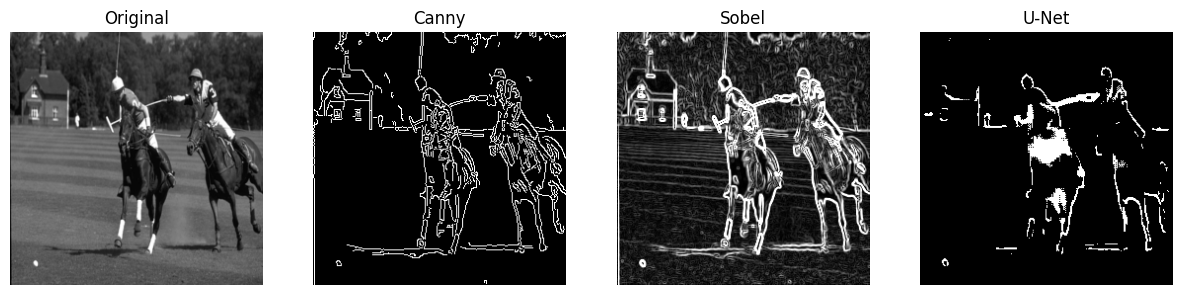

In [481]:
'''
Given RGB image predict edge map using pre-trained U-Net
'''
def predict_edge_map(model, image, device, threshold=0.45):
    # Apply same transformations used for training
    image_tensor = transform_img(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        # Apply sigmoid to get probabilities
        output = torch.sigmoid(output)
        # Squeeze and convert to np.array
        output_np = output.squeeze().cpu().numpy()
        # If output has 2 channels, take second as edge map
        if output_np.ndim == 3 and output_np.shape[0] == 2:
            output_np = output_np[1]
        # Get a binary edge map
        edge_map = (output_np > threshold).astype(np.uint8) * 255
    return edge_map

# Create dataset and dataloader
val_dataset = BSDSDataset(root_dir='BSR', split='val', transform_img=transform_img, transform_mask=transform_mask, fill_mask=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0)

# Get single sample from validation set
sample_image, sample_mask = next(iter(val_loader))

# Convert tensor image back to numpy array
sample_image_np = (sample_image.squeeze().permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)

# Get edge maps from Canny and Sobel
edges_canny = apply_canny(sample_image_np)
edges_sobel = apply_sobel(sample_image_np)

# Get edge map from pre-trained U-Net model
edges_unet = predict_edge_map(model, sample_image_np, device)

# Visualize all three results side by side
plt.figure(figsize=(15, 5))

plt.subplot(1,4,1)
plt.title("Original")
plt.imshow(sample_image_np, cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)
plt.title("Canny")
plt.imshow(edges_canny, cmap='gray')
plt.axis('off')

plt.subplot(1,4,3)
plt.title("Sobel")
plt.imshow(edges_sobel, cmap='gray')
plt.axis('off')

plt.subplot(1,4,4)
plt.title("U-Net")
plt.imshow(edges_unet, cmap='gray')
plt.axis('off')

plt.show()